In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

ts = True
try:
    from torchsummary import summary
except:
    ts = False
    print("Not found torchsummary, please install it.")
    

In [2]:
train_ratio = 0.7
val_ratio = 0.15
# test_ratio = 0.2

# train_ratio = 0.8
# val_ratio = 0.2

max_epochs = 20
batch_size = 32
num_workers = 4

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        # self.fc1 = nn.Linear(64 * 5 * 5, 128)
        # self.fc2 = nn.Linear(128, 10)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x))) # 16 * 13 * 13
        x = self.pool2(torch.relu(self.conv2(x))) # 32 * 5 * 5
        x = x.view(-1, 32 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        # x = self.fc2(x)
        x = self.softmax(x)
        return x

In [24]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 16 * 13 * 13
        x = self.pool(torch.relu(self.conv2(x))) # 32 * 5 * 5
        x = x.view(-1, 32 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [35]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 32 * 12 * 12
        x = self.pool(torch.relu(self.conv2(x))) # 64 * 4 * 4
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        return x

In [40]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # 32 * 14 * 14
        x = self.pool(torch.relu(self.conv2(x))) # 64 * 7 * 7
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = self.softmax(x)
        return x

In [7]:
def get_layers(model):
    layers = dict()
    for name, layer in model.named_children():
        layers[name] = layer
    return layers

In [8]:
def visualize_feature_maps(model, layer_name, input_image):
    model.eval()

    target_layer = None
    for name, layer in model.named_modules():
        # print(name)
        if name == layer_name:
            target_layer = layer
    
    if target_layer is None:
        raise ValueError(f"Layer {layer_name} not found in the model.")
    
    def hook(module, input, output):
        global feature_maps
        feature_maps = output.detach().cpu()

    hook_handle = target_layer.register_forward_hook(hook)
    with torch.no_grad():
        model(input_image.to(device))
    
    hook_handle.remove()

    # with torch.no_grad():
    #     feature_maps = target_layer(input_image.unsqueeze(0).to(device)).squeeze()

    print(f"Shape of feature maps: {feature_maps.size()}")

    num_feature_maps = feature_maps.size(0)
    feature_map_size = feature_maps.size(1)
    num_rows = num_feature_maps // 8  # Arrange the feature maps in rows of 8
    fig, axes = plt.subplots(num_rows, 8, figsize=(16, 2 * num_rows))

    for i in range(num_feature_maps):
        row = i // 8
        col = i % 8
        ax = axes[row, col]
        ax.imshow(feature_maps[i].cpu(), cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Feature Map {i+1}")

    # Hide any remaining empty subplots
    for i in range(num_feature_maps, num_rows * 8):
        row = i // 8
        col = i % 8
        axes[row, col].axis('off')

    fig.suptitle(f"Feature Maps of Layer {layer_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [9]:
def train(max_epochs, save_model=None, graph=False):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []

    for epoch in range(max_epochs):
        running_loss = 0.0
        epoch_less = 0
        no_test = 0
        accuracy = 0
        
        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            epoch_less += loss.item()
            no_test += len(labels)
            accuracy += (outputs.argmax(dim=1) == labels).float().sum().item()
            
            if (i + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        
        train_losses.append(epoch_less / len(train_loader))
        train_acc.append(accuracy / no_test)

        # Validation
        model.eval()
        epoch_loss = 0
        no_val = 0
        accuracy = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()

                accuracy += (outputs.argmax(dim=1) == labels).float().sum().item()
                no_val += len(labels)
        val_losses.append(epoch_loss / len(val_loader))
        val_acc.append(accuracy / no_val)

        print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Accuracy: {val_acc[-1]:.3f}")

    print("Finished Training")

    if save_model is not None:
        torch.save(model.state_dict(), save_model)
        print(f"Saved PyTorch Model State to {save_model}")
    
    if graph:
        plt.figure(figsize=(12, 8))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Losses')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.plot(train_acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Training and Validation Accuracy')
        plt.show()

    return train_losses, val_losses, train_acc, val_acc


In [10]:
def test(test_loader):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the test dataset: {accuracy:.2f}%")

### Main Code

In [11]:
model = BaselineNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
get_layers(model)

{'conv1': Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
 'pool1': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 'conv2': Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)),
 'pool2': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 'fc1': Linear(in_features=800, out_features=10, bias=True),
 'dropout': Dropout(p=0.5, inplace=False),
 'softmax': Softmax(dim=1)}

In [13]:
if ts:
    summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
         MaxPool2d-2           [-1, 16, 13, 13]               0
            Conv2d-3           [-1, 32, 11, 11]           4,640
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Linear-5                   [-1, 10]           8,010
           Dropout-6                   [-1, 10]               0
           Softmax-7                   [-1, 10]               0
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.05
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [14]:
dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True)

dataset_size = len(dataset)
print('Number of images: ', dataset_size)

Number of images:  60000


6742 5421 Difference: 1321


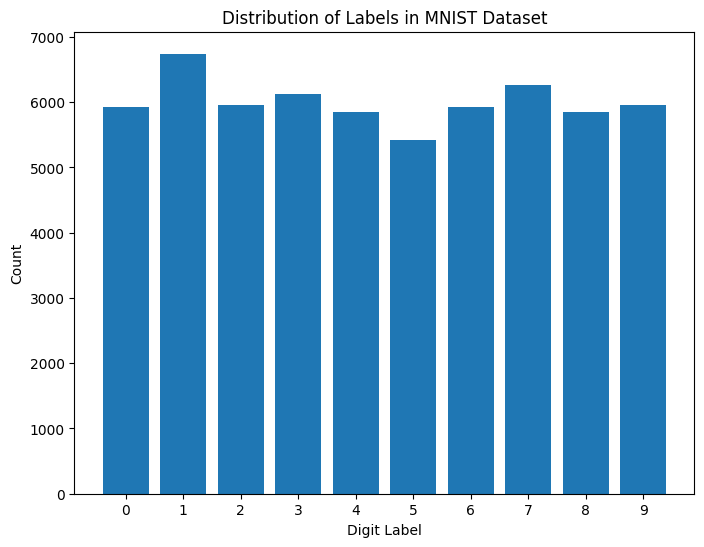

In [15]:
labels = dataset.targets.numpy()
label_counts = np.bincount(labels)

print(np.max(label_counts), np.min(label_counts), "Difference:", np.max(label_counts) - np.min(label_counts))

plt.figure(figsize=(8, 6))
plt.bar(range(10), label_counts, tick_label=np.arange(10))
plt.xlabel("Digit Label")
plt.ylabel("Count")
plt.title("Distribution of Labels in MNIST Dataset")
plt.show()

> Class Imbalance

No, there doesn't seem to be any class imbalance as such (except a small one of around 10% at max) in the dataset. The dataset is fairly balanced, and can be used for training without any class imbalance issues.

In [16]:
samples_per_class = {label: [] for label in range(10)}

for i, (image, label) in enumerate(dataset):
    if len(samples_per_class[label]) < 5:
        samples_per_class[label].append(image)
    if all(len(samples) == 5 for samples in samples_per_class.values()):
        break

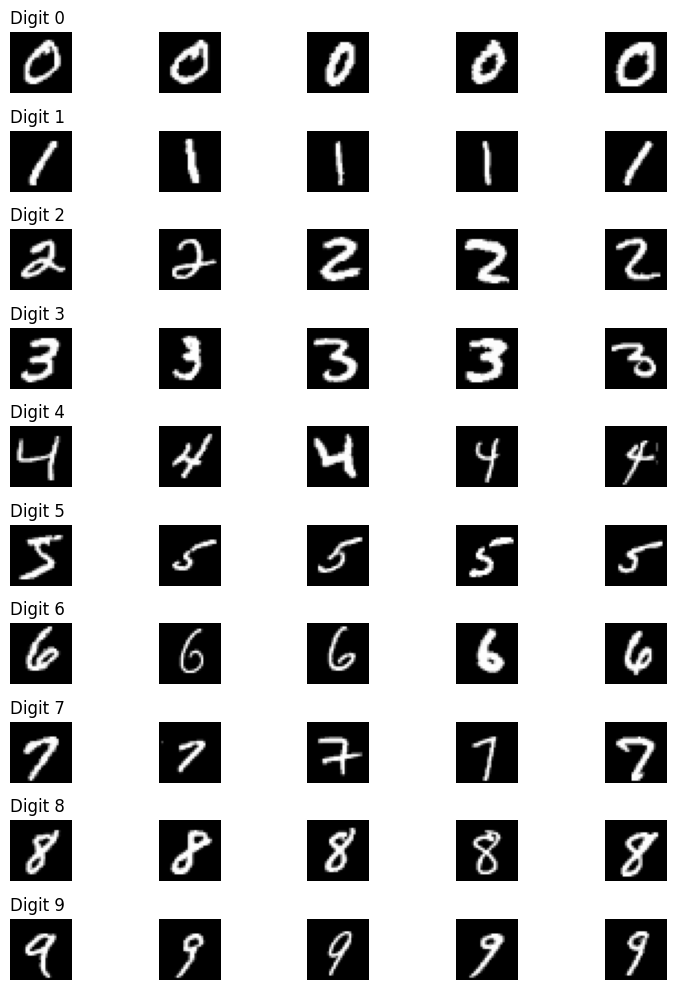

In [17]:
plt.figure(figsize=(8, 10))
for label, samples in samples_per_class.items():
    for i, sample in enumerate(samples):
        plt.subplot(10, 5, label * 5 + i + 1)
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Digit {label}', loc='left')
plt.tight_layout()
plt.show()

In [18]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# To put the data into a DataLoader, we need to convert it into a TensorDataset first

In [19]:
train_set, val_set, test_set = Data.random_split(
    train_dataset, [
        int(train_ratio * dataset_size),
        int(val_ratio * dataset_size),
        int((1 - train_ratio - val_ratio) * dataset_size)
    ]
)

train_loader = Data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)
test_loader1 = Data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

Epoch 1, Batch 100, Loss: 2.235
Epoch 1, Batch 200, Loss: 2.211
Epoch 1, Batch 300, Loss: 2.188
Epoch 1, Batch 400, Loss: 2.187
Epoch 1, Batch 500, Loss: 2.189
Epoch 1, Batch 600, Loss: 2.189
Epoch 1, Batch 700, Loss: 2.172
Epoch 1, Batch 800, Loss: 2.142
Epoch 1, Batch 900, Loss: 2.148
Epoch 1, Batch 1000, Loss: 2.146
Epoch 1, Batch 1100, Loss: 2.151
Epoch 1, Batch 1200, Loss: 2.143
Epoch 1, Batch 1300, Loss: 2.140
Epoch 1, Train Loss: 2.172, Val Loss: 1.984, Accuracy: 0.405
Epoch 2, Batch 100, Loss: 2.139
Epoch 2, Batch 200, Loss: 2.139
Epoch 2, Batch 300, Loss: 2.133
Epoch 2, Batch 400, Loss: 2.141
Epoch 2, Batch 500, Loss: 2.143
Epoch 2, Batch 600, Loss: 2.133
Epoch 2, Batch 700, Loss: 2.141
Epoch 2, Batch 800, Loss: 2.144
Epoch 2, Batch 900, Loss: 2.140
Epoch 2, Batch 1000, Loss: 2.140
Epoch 2, Batch 1100, Loss: 2.127
Epoch 2, Batch 1200, Loss: 2.128
Epoch 2, Batch 1300, Loss: 2.135
Epoch 2, Train Loss: 2.137, Val Loss: 1.976, Accuracy: 0.407
Epoch 3, Batch 100, Loss: 2.140
Epoch 

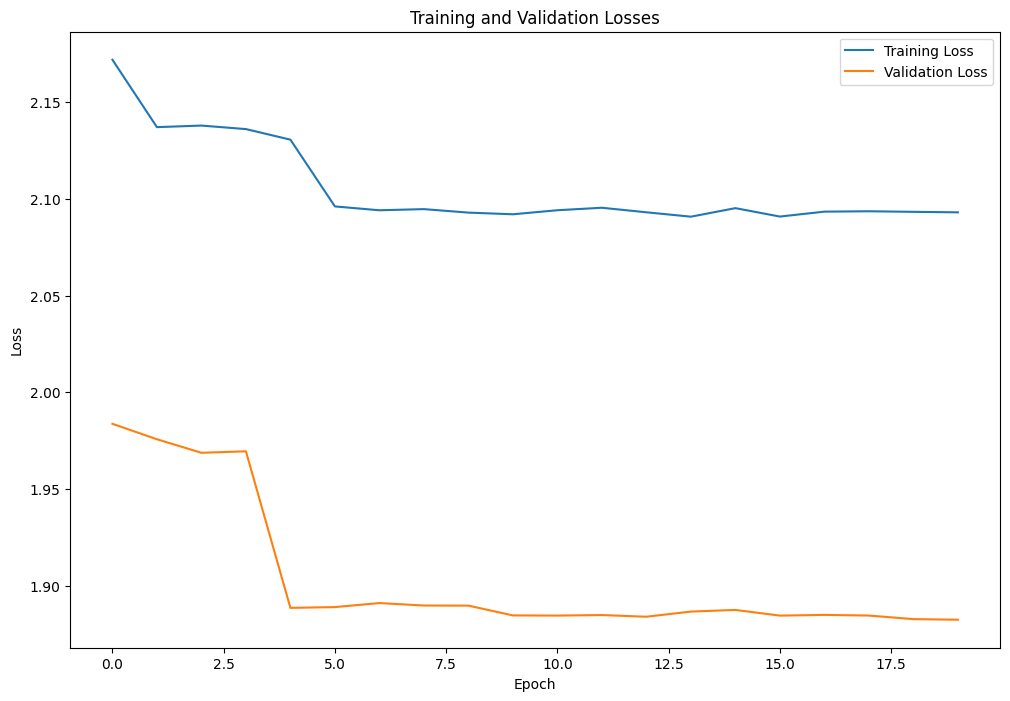

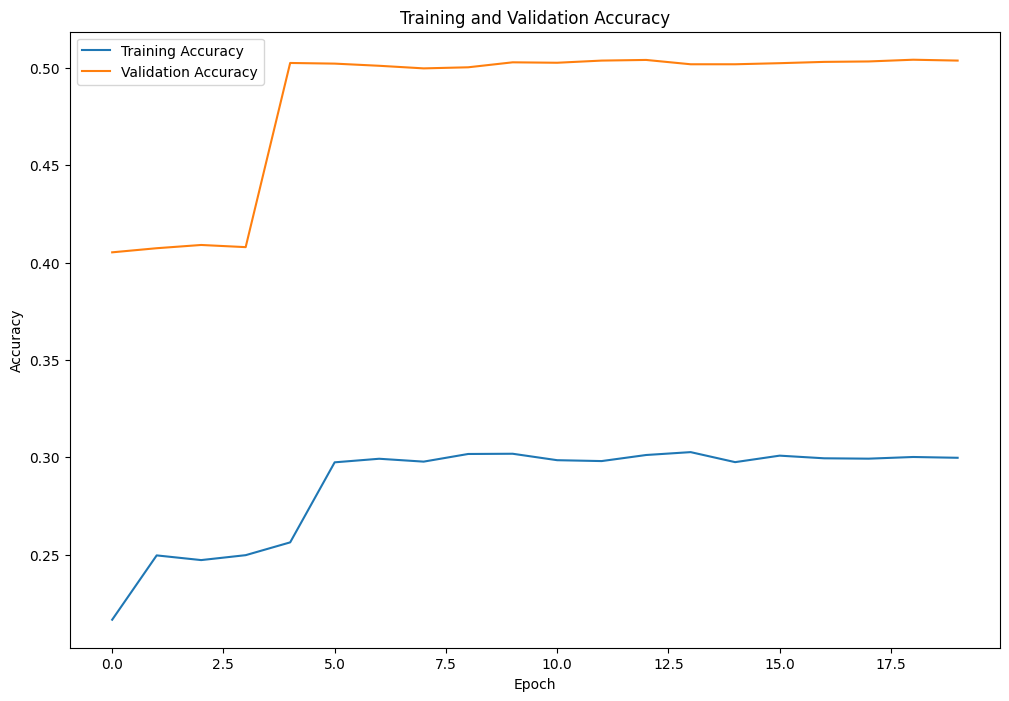

In [20]:
train_losses, val_losses, train_acc, val_acc = train(max_epochs, "../models/baseline_model_mnist.pth", graph=True)

In [21]:
print("On Test Split Set")
test(test_loader)
print("On Test Set")
test(test_loader1)


On Test Split Set
Accuracy on the test dataset: 50.66%
On Test Set
Accuracy on the test dataset: 50.92%


Shape of feature maps: torch.Size([16, 26, 26])


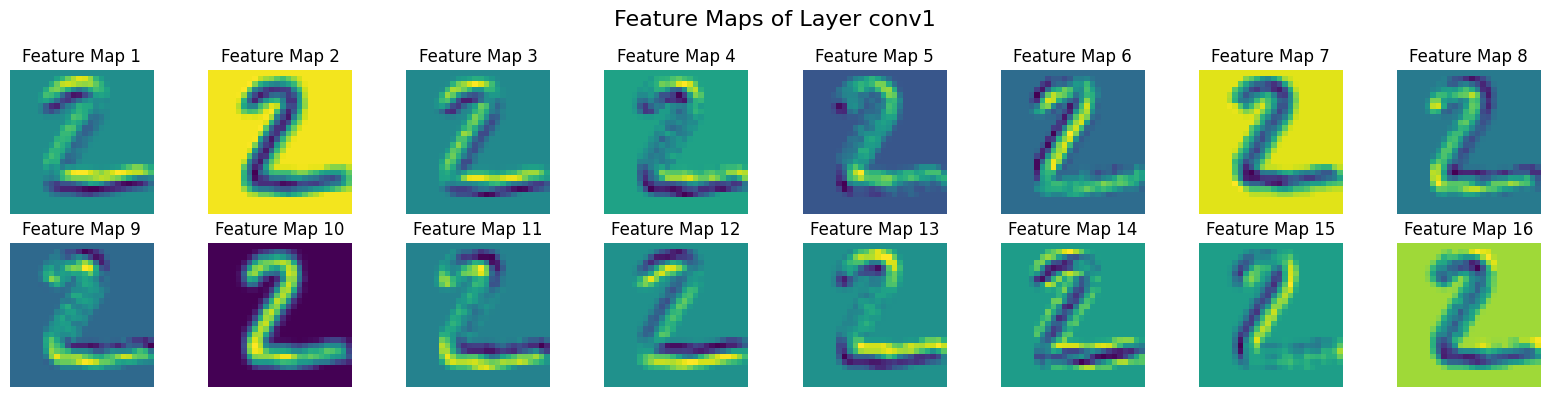

Shape of feature maps: torch.Size([16, 13, 13])


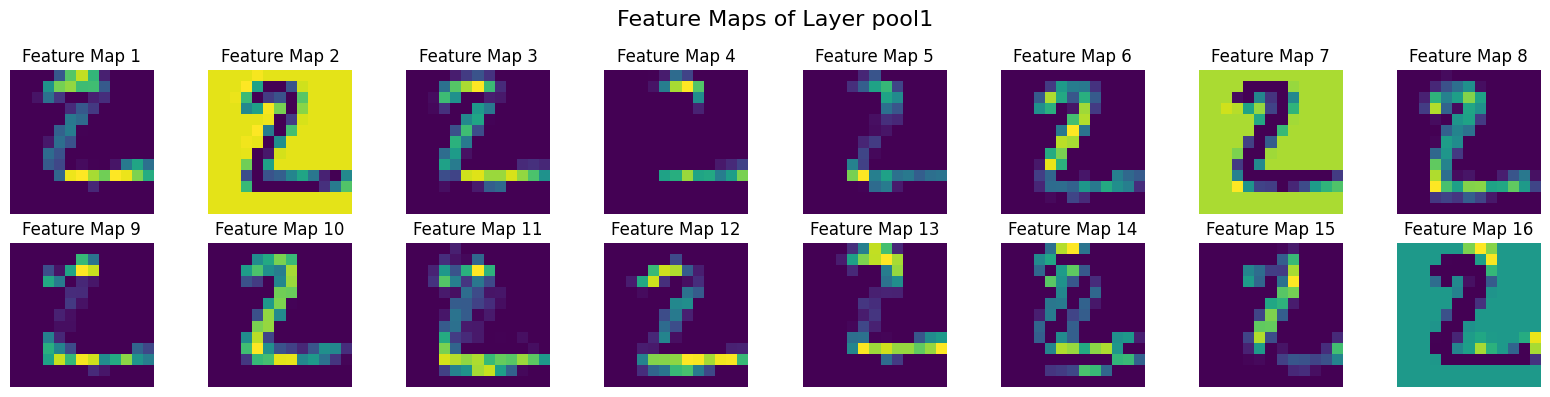

Shape of feature maps: torch.Size([32, 11, 11])


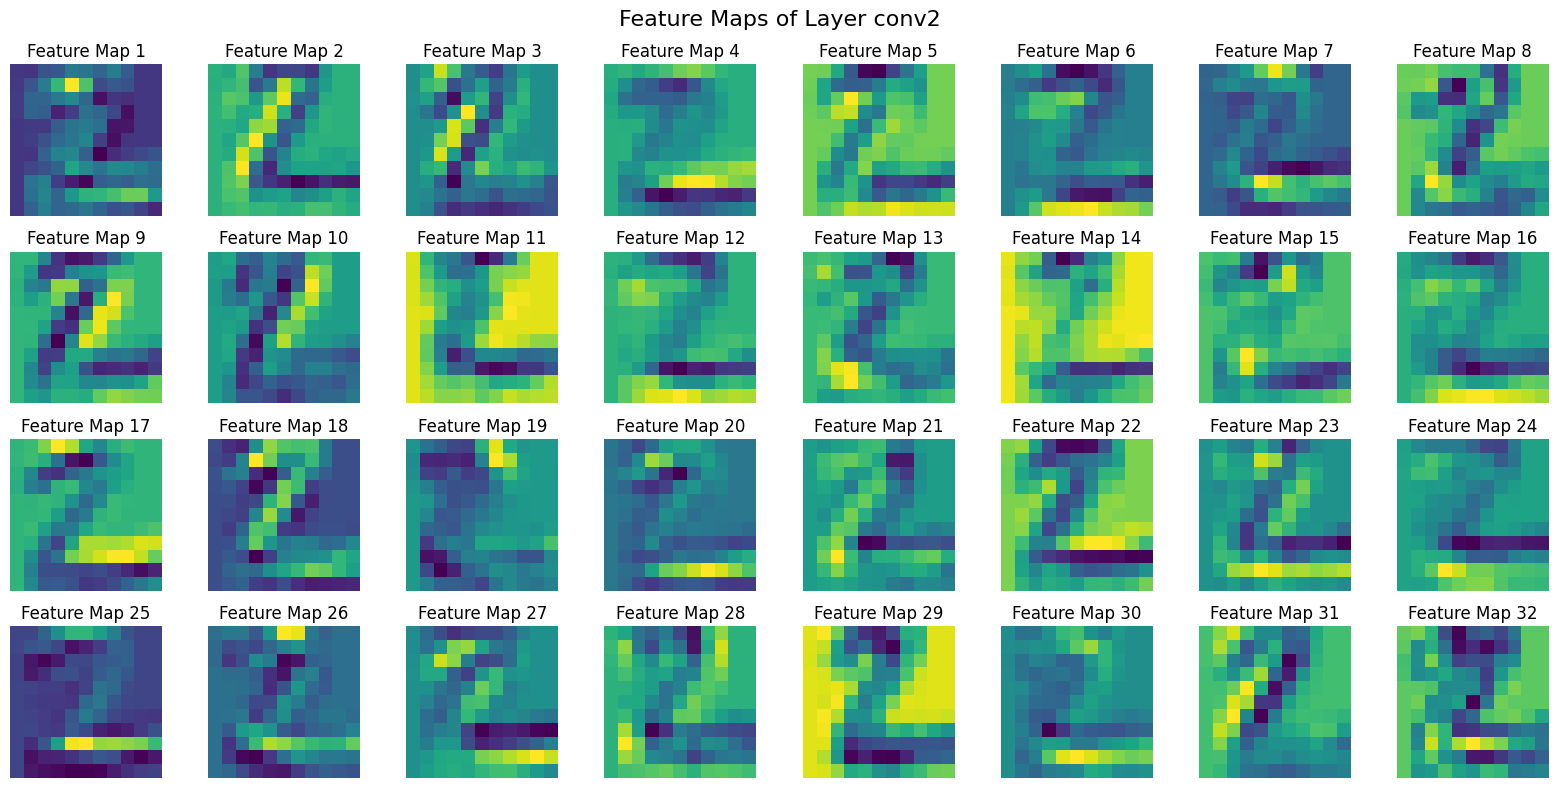

In [22]:
visualize_feature_maps(model, 'conv1', test_dataset[1][0])
visualize_feature_maps(model, 'pool1', test_dataset[1][0])
visualize_feature_maps(model, 'conv2', test_dataset[1][0])

> Explanation about Feature Maps

As we can see from the above feature maps for different layers that they are able to capture different features of the image. The first layer is able to capture the edges of the image, the second layer is able to capture the shape of the image more effectively (We can see that it has features captured almost spatially invariant, so as to prevent over generalization, which layers 1 is doing more than this one). This is because the first layer is able to capture the low level features, and the second layer is able to capture the high level features.

Epoch 1, Batch 100, Loss: 2.106
Epoch 1, Batch 200, Loss: 1.778
Epoch 1, Batch 300, Loss: 1.688
Epoch 1, Batch 400, Loss: 1.653
Epoch 1, Batch 500, Loss: 1.623
Epoch 1, Batch 600, Loss: 1.611
Epoch 1, Batch 700, Loss: 1.595
Epoch 1, Batch 800, Loss: 1.589
Epoch 1, Batch 900, Loss: 1.583
Epoch 1, Batch 1000, Loss: 1.579
Epoch 1, Batch 1100, Loss: 1.570
Epoch 1, Batch 1200, Loss: 1.564
Epoch 1, Batch 1300, Loss: 1.563
Epoch 1, Train Loss: 1.653, Val Loss: 1.501, Accuracy: 0.962
Epoch 2, Batch 100, Loss: 1.556
Epoch 2, Batch 200, Loss: 1.550
Epoch 2, Batch 300, Loss: 1.557
Epoch 2, Batch 400, Loss: 1.551
Epoch 2, Batch 500, Loss: 1.548
Epoch 2, Batch 600, Loss: 1.552
Epoch 2, Batch 700, Loss: 1.535
Epoch 2, Batch 800, Loss: 1.542
Epoch 2, Batch 900, Loss: 1.536
Epoch 2, Batch 1000, Loss: 1.539
Epoch 2, Batch 1100, Loss: 1.532
Epoch 2, Batch 1200, Loss: 1.541
Epoch 2, Batch 1300, Loss: 1.526
Epoch 2, Train Loss: 1.543, Val Loss: 1.490, Accuracy: 0.972
Epoch 3, Batch 100, Loss: 1.526
Epoch 

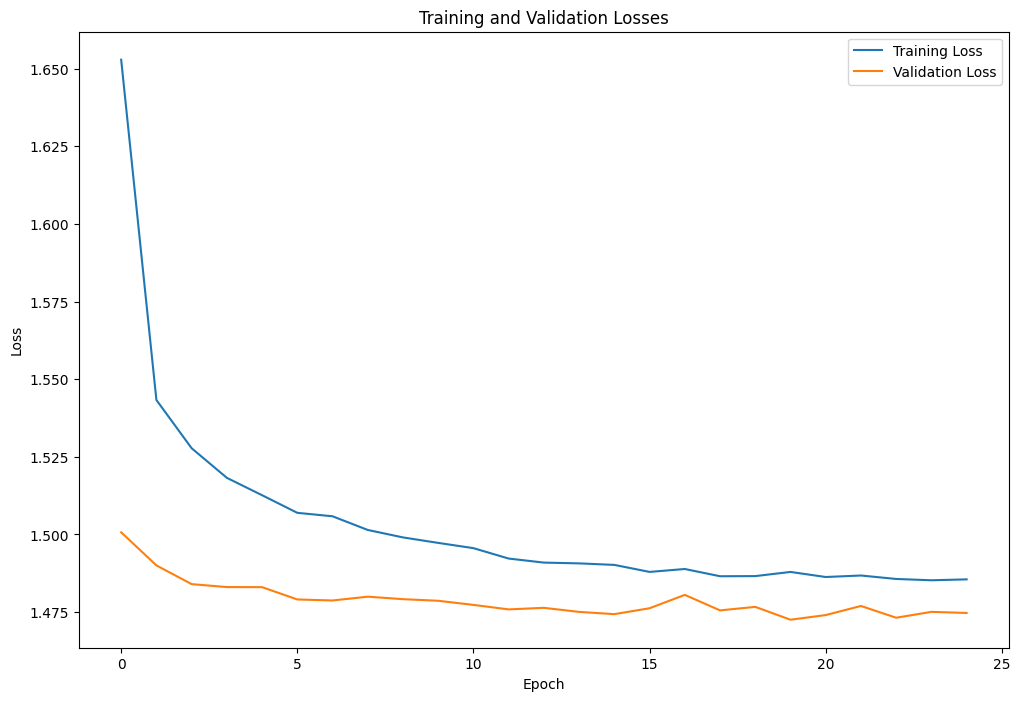

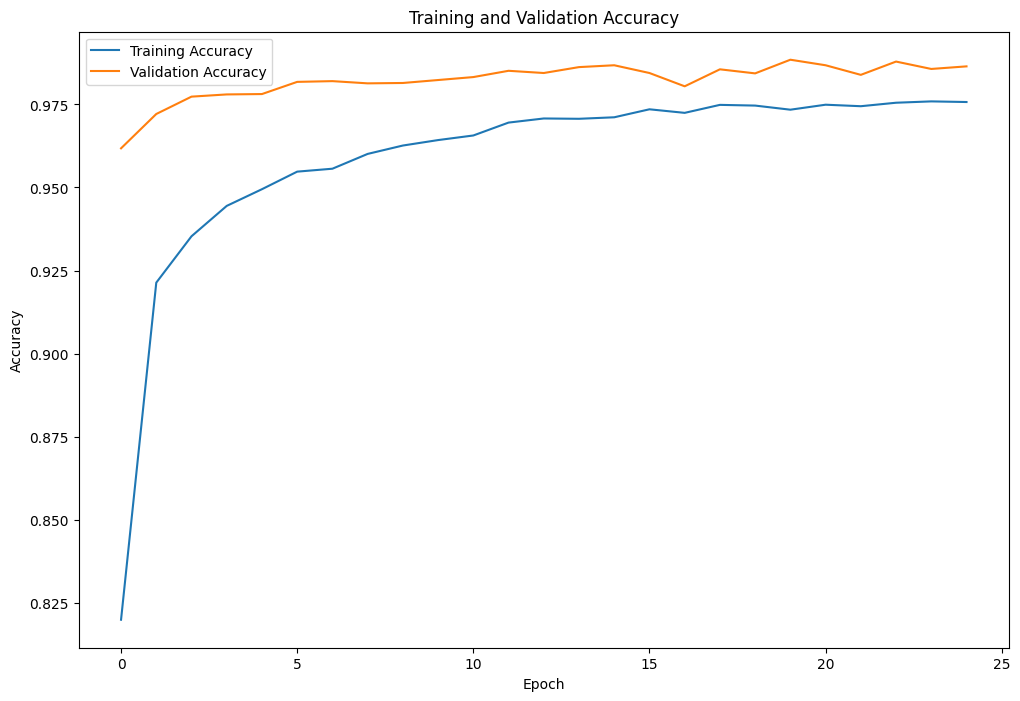

On Test Split Set
Accuracy on the test dataset: 98.46%
On Test Set
Accuracy on the test dataset: 98.65%


In [33]:
model = Net1()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_acc, val_acc = train(max_epochs + 5, graph=True)

print("On Test Split Set")
test(test_loader)
print("On Test Set")
test(test_loader1)

Epoch 1, Batch 100, Loss: 1.015
Epoch 1, Batch 200, Loss: 0.358
Epoch 1, Batch 300, Loss: 0.264
Epoch 1, Batch 400, Loss: 0.225
Epoch 1, Batch 500, Loss: 0.196
Epoch 1, Batch 600, Loss: 0.157
Epoch 1, Batch 700, Loss: 0.153
Epoch 1, Batch 800, Loss: 0.142
Epoch 1, Batch 900, Loss: 0.130
Epoch 1, Batch 1000, Loss: 0.145
Epoch 1, Batch 1100, Loss: 0.146
Epoch 1, Batch 1200, Loss: 0.107
Epoch 1, Batch 1300, Loss: 0.117
Epoch 1, Train Loss: 0.241, Val Loss: 0.056, Accuracy: 0.984
Epoch 2, Batch 100, Loss: 0.102
Epoch 2, Batch 200, Loss: 0.076
Epoch 2, Batch 300, Loss: 0.086
Epoch 2, Batch 400, Loss: 0.098
Epoch 2, Batch 500, Loss: 0.083
Epoch 2, Batch 600, Loss: 0.095
Epoch 2, Batch 700, Loss: 0.083
Epoch 2, Batch 800, Loss: 0.092
Epoch 2, Batch 900, Loss: 0.077
Epoch 2, Batch 1000, Loss: 0.074
Epoch 2, Batch 1100, Loss: 0.095
Epoch 2, Batch 1200, Loss: 0.078
Epoch 2, Batch 1300, Loss: 0.074
Epoch 2, Train Loss: 0.086, Val Loss: 0.046, Accuracy: 0.986
Epoch 3, Batch 100, Loss: 0.080
Epoch 

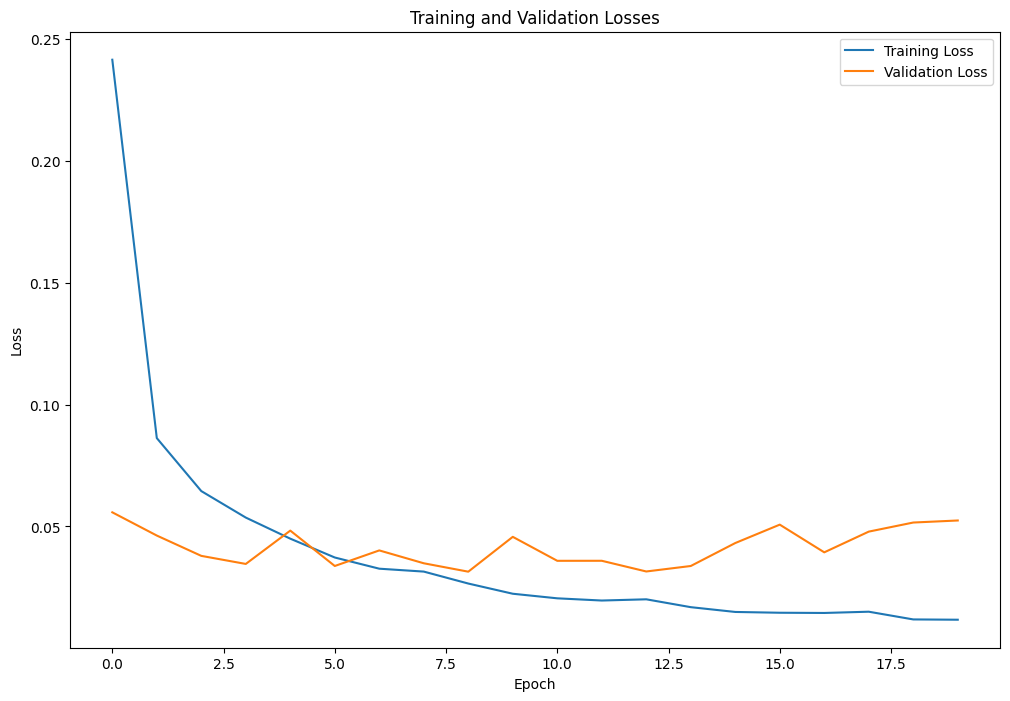

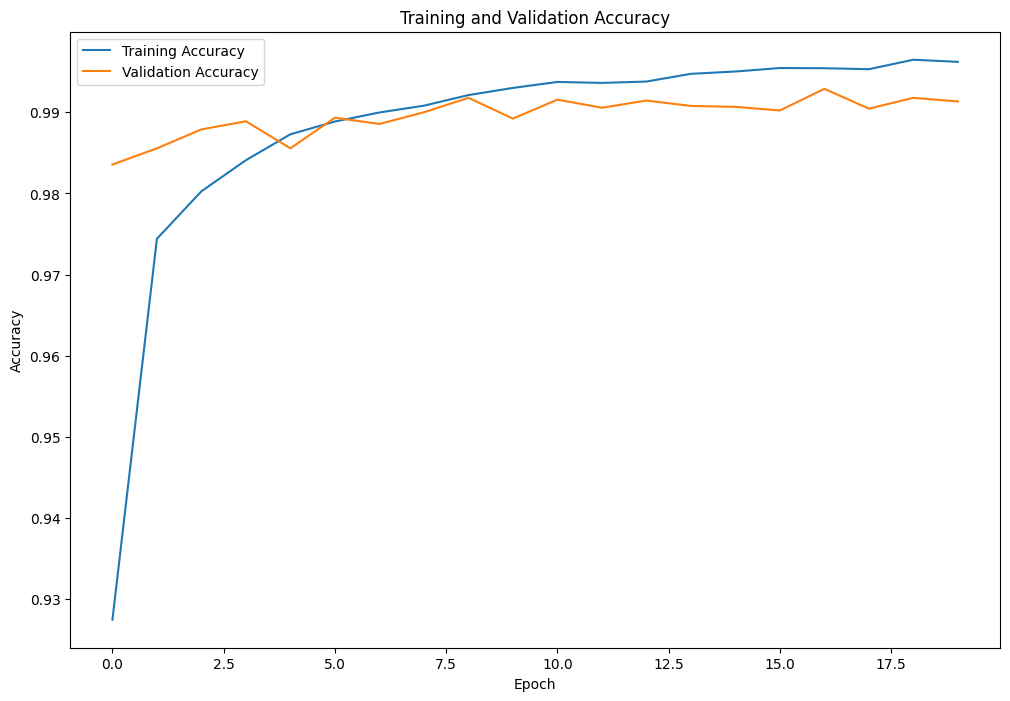

On Test Split Set
Accuracy on the test dataset: 98.92%
On Test Set
Accuracy on the test dataset: 99.17%


In [32]:
model = Net2()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_acc, val_acc = train(max_epochs, graph=True)

print("On Test Split Set")
test(test_loader)
print("On Test Set")
test(test_loader1)

Epoch 1, Batch 100, Loss: 1.093
Epoch 1, Batch 200, Loss: 0.369
Epoch 1, Batch 300, Loss: 0.258
Epoch 1, Batch 400, Loss: 0.219
Epoch 1, Batch 500, Loss: 0.187
Epoch 1, Batch 600, Loss: 0.169
Epoch 1, Batch 700, Loss: 0.174
Epoch 1, Batch 800, Loss: 0.134
Epoch 1, Batch 900, Loss: 0.132
Epoch 1, Batch 1000, Loss: 0.138
Epoch 1, Batch 1100, Loss: 0.144
Epoch 1, Batch 1200, Loss: 0.129
Epoch 1, Batch 1300, Loss: 0.101
Epoch 1, Train Loss: 0.248, Val Loss: 0.053, Accuracy: 0.983
Epoch 2, Batch 100, Loss: 0.095
Epoch 2, Batch 200, Loss: 0.118
Epoch 2, Batch 300, Loss: 0.094
Epoch 2, Batch 400, Loss: 0.090
Epoch 2, Batch 500, Loss: 0.097
Epoch 2, Batch 600, Loss: 0.087
Epoch 2, Batch 700, Loss: 0.098
Epoch 2, Batch 800, Loss: 0.089
Epoch 2, Batch 900, Loss: 0.080
Epoch 2, Batch 1000, Loss: 0.097
Epoch 2, Batch 1100, Loss: 0.089
Epoch 2, Batch 1200, Loss: 0.086
Epoch 2, Batch 1300, Loss: 0.079
Epoch 2, Train Loss: 0.092, Val Loss: 0.049, Accuracy: 0.984
Epoch 3, Batch 100, Loss: 0.061
Epoch 

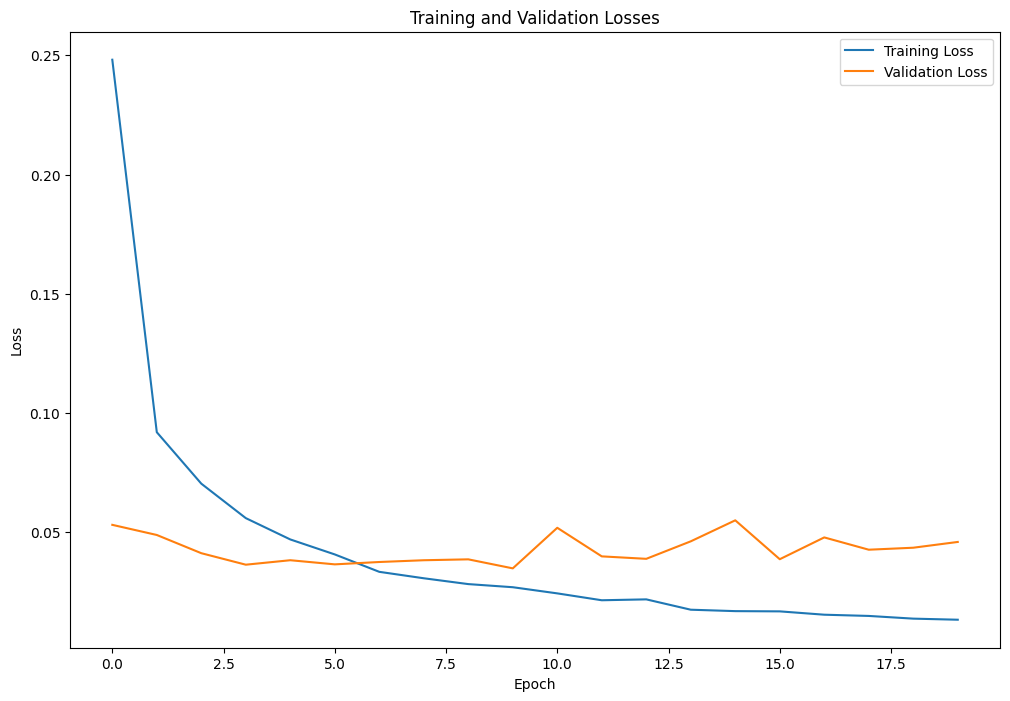

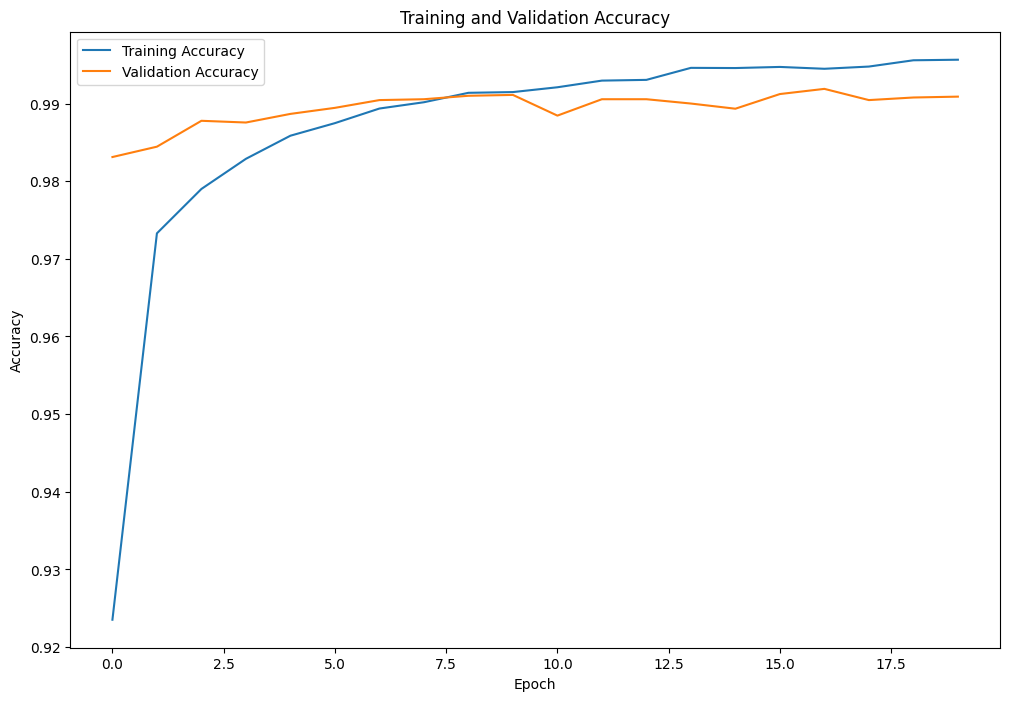

On Test Split Set
Accuracy on the test dataset: 99.03%
On Test Set
Accuracy on the test dataset: 99.20%


In [41]:
model = Net3()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, train_acc, val_acc = train(max_epochs, graph=True)

print("On Test Split Set")
test(test_loader)
print("On Test Set")
test(test_loader1)